## API Class

In [28]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from os.path import isfile, join
import os
%matplotlib inline

class Gemtek_restful_api:
    def __init__(self, URL, api_key, api_secret, macID, index = 0, limit = 10, start_time = 0):
        self.URL = URL
        self.api_key = api_key
        self.api_secret = api_secret
        self.macID = macID
        self.index = index
        self.limit = limit
        self.start_time = start_time
        self.end_time = 0
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload = {
            "index": self.index,
            "mac" : self.macID,
            "api_key" : self.api_key,
            "api_token" : self.api_token,
            "time" : self.time,
        }
        self.jsonData = None
        self.request_OK = None
        self.jsonDataLength = None
        
        if len(macID) != 12:
            print("mac address is ilegal !!")
        
    def set_query_index(self, index ):
        self.index = index
        self.payload["index"] = self.index

    def set_query_limit(self, limit ):
        self.limit = limit
        self.payload["limit"] = self.limit
        
    def set_query_start_time(self, start_time = 0):
        self.start_time = start_time  
        self.payload["start_time"] = self.start_time

    def set_query_end_time(self, end_time):
        self.end_time = end_time
        self.payload["end_time"] = self.end_time
        
    def get_query_start_time(self):
        return self.start_time

    def get_query_end_time(self):
        return self.end_time
    
    def set_query_mac(self, macID):
        self.macID = macID  
        self.payload["mac"] = self.macID
        
    def print_API_parameter(self):
        print("------------- RESTful API parameter --------------")
        print("mac: ", self.macID)
        print("api_key: ", self.api_key)
        print("api_secret: ", self.api_secret)
        print("unix_time: ", self.time)
        print("api_token: ", self.api_token)
        print("index: ", self.index, "limit: ", self.limit)
        print("Payload:", self.payload)
        print("--------------------------------------------------\n")
        
    def get_query_data(self):    
        req = requests.post(self.URL, json = self.payload)
        self.jsonData = req.json()
#         print("jsonData", self.jsonData)
        self.jsonDataLength = self.jsonData['value']['total']
        server_ReturnCode = self.jsonData['status']['code']
        server_ReturnMsg = self.jsonData['status']['message']
        
        if (server_ReturnCode == 1200):
            self.request_OK = True
        else:
            self.request_OK = False
        
#         print("------------- Request Status ---------------------")
#         print("Request URL: ", req.url)
#         print("Server return code: ",server_ReturnCode, ", Msg :", server_ReturnMsg)
#         print("Packet Length: ", self.jsonDataLength)
#         print("--------------------------------------------------\n")
     
        return self.jsonData
    
    def update_new_api_token(self):    
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload["time"] = self.time
        self.payload["api_token"] = self.api_token
    


In [29]:
def check_file_path_exist(csvName):
    if not os.path.exists(os.path.dirname(csvName)):
        try:
            os.makedirs(os.path.dirname(csvName))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def get_datetime_from_timeString(date_string):
    date_string = date_string.replace('T',' ').replace('Z','')
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f')
    return datetime_object

def get_two_datetime_delta(datetime_object1 , datetime_object2):
    datetime_delta   = datetime_object2 - datetime_object1
    return datetime_delta.total_seconds()

In [30]:
def byteToMagData(Low_byte, High_byte):
    value = int(Low_byte.encode(), 16) + int(High_byte.encode(), 16) * 256
    return twos_comp(value, 16)

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val 

def getPraseTargetData(Data):
    prase_data = Data['value']['hits']
    prase_data_from_json = []
    latency_time_list = list()
    create_time_list  = list()
    # 'Asia/Taipei' LMT+8:06:00 STD
    TPE_UTC_offset = 60*60*8 
    
    # columes in data frame
    prase_data_columes = ['_id', '_index', 'mac','create_at_time','recv_at_time','frameCnt', 'data',
                          'company','road','slot_num','gwip','rssi','snr',
                          "timestamp","latency_time","magX", "magY", "magZ","mag_len" ,"magT"]

    # get data by list
    for each in prase_data:
        fullData = []
        pakcetHeader = "fcffff07"
        packetByte = []
        
        fullData = [ each['_id'], each['_index'], each['_source']['macAddr'],
             each['_source']['create_at'], each['_source']['recv'], each['_source']['frameCnt'],
             each['_source']['data'], 
             each['_source']['extra']['company'],  each['_source']['extra']['road'], 
             each['_source']['extra']['slot_num'], each['_source']['gwip'],
             # each['_source']['dataParse']['voltage'], each['_source']['dataParse']['lowBattery'],
             each['_source']['rssi'], each['_source']['snr']
        ]
        
        create_time = get_datetime_from_timeString( each['_source']['create_at'])
        recv_time   = get_datetime_from_timeString( each['_source']['recv'] )
        latency_time = get_two_datetime_delta( recv_time , create_time )
        
        # get high/ low byte
        packetMagData = each['_source']['data']
        
        index = [i for i in range(len(packetMagData)) if i % 2 == 0]   
        for each in index:
            packetByte.append(packetMagData[each:each+2])
        
#         print("packet Byte: ", packetByte)
        
        magX = byteToMagData(packetByte[-7], packetByte[-6])
        magY = byteToMagData(packetByte[-5], packetByte[-4])
        magZ = byteToMagData(packetByte[-3], packetByte[-2])
        magT = byteToMagData(packetByte[-1], '00')
        maglen = (magX**2 + magY**2 + magZ**2)**(0.5)

        fullData.extend([recv_time.timestamp() + TPE_UTC_offset, latency_time, magX, magY, magZ, maglen, magT])
#         print("Data:", fullData)
        prase_data_from_json.append(fullData)
    return pd.DataFrame(prase_data_from_json, columns=prase_data_columes) 


In [36]:
def fast_plot_line(figure, axis, index, time , x, y, z, length ,title, ylimit):
    indexRow = int(index%5)
    indexCol = int(index/5)
    axis[indexRow][indexCol].plot()
    axis[indexRow][indexCol].plot(time, x, label='magX')
    axis[indexRow][indexCol].plot(time, y, label='magY')
    axis[indexRow][indexCol].plot(time, z, label='magZ')
    axis[indexRow][indexCol].plot(time, length, label='magLen')
#     axis[index][0].set_xlabel('Time')
    axis[indexRow][indexCol].set_ylabel('Mag Value')
    axis[indexRow][indexCol].set_title(title)
    axis[indexRow][indexCol].legend()
    axis[indexRow][indexCol].grid()
    if ylimit:
        axis[index].set_ylim([-100, 100])
    return None

def plot_basic_plot(count, magX, magY, magZ, title):
    plt.figure()
    plt.plot(count, magX, label='magX')
    plt.plot(count, magY, label='magY')
    plt.plot(count, magZ, label='magZ')
    plt.xlabel('Time')
    plt.ylabel('Mag Value')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def get_secific_time_data(data, ex_start_time, ex_end_time , offset = 0):
    data = data.loc[data['timestamp'] >= ex_start_time ]
    data = data.loc[data['timestamp'] <= ex_end_time]
    data = data.drop_duplicates(['frameCnt'])
    data = data.sort_values(['frameCnt'])
    return data

def get_data_lose_rate(node_name, expected_points, actual_points):
    lose_Point = int(expected_points - actual_points)
    lose_Rate = lose_Point / query_data_points * 100
    print("Node:", node_name, " - data pts in this period:", dfenvlen, 
          ", data lose pts:", lose_Point, ", lose rate:", lose_Rate )
    
def get_mag_offset_data(data, EnvMagX, EnvMagY, EnvMagZ, offset = 60*60*8):

    data["count"] = pd.to_datetime((data['timestamp'] + offset).astype(int),unit='s')
    data["magX_of"] = data["magX"] - EnvMagX
    data["magY_of"] = data["magY"] - EnvMagY
    data["magZ_of"] = data["magZ"] - EnvMagZ
    data["magLen_of"] = (data["magX_of"].pow(2) + data["magY_of"].pow(2) + data["magZ_of"].pow(2) ).pow(0.5)
    return data

In [31]:
import time
from datetime import datetime

current_time = int(round(time.time()))
print("current unix time (sec): ",current_time)


current_milli_time = lambda: int(round(time.time() * 1000))
print("current unix time (ms): ",current_milli_time())


current unix time (sec):  1503051558
current unix time (ms):  1503051558277


## 1. update data from server

In [40]:
#-*- coding=utf-8 -*-
import os, sys, errno
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import threading

URL = "https://s5.securepilot.com/parking/v1/query_record"
api_key = "PARK-eMPpua7y17"
api_secret = "2PHIAGI5qv5IhMGZ56iy"


# mac_gemtek = "101a"
# mac_address1 = mac_gemtek + "0d0100ab"
# mac_address_test = mac_gemtek + "0d0100cc"

mac_gemtek = "101a"
mac_list = ["0d0100d9","0d0100dc","0d0100b5",
            "0d0100b8","0d01019a","0d0100c0",
            "0d0100e4","0d0100cb","None",
            "0d0100a3","0d0101e4","0d0100cc",
            "0d0100da","0d010119","0d0101eb" ]
mac_query_list = [mac_gemtek + f for f in  mac_list]

matrix_node = ["L1","M1", "R1", 
                "L2","M2", "R2",
                "L3","M3", "R3",
                "L4","M4", "R4",
                "L5","M5", "R5"]

mac_query_dict = dict(zip(matrix_node, mac_query_list))

######################### Query loop ####################   
def query_AWS_data(dfcsv, api, csvName, enable_threading = False ):
    if enable_threading == True:
        threading.Timer(10.0, query_AWS_data).start()
    
    data_send_interval = 3
    timestamp_sec_to_ms = 1000
    retry_counter = 5
    # new timestamp to query
    query_start_timestamp = api.get_query_start_time()
    csv_start_timestamp = int(dfcsv.timestamp[0] * timestamp_sec_to_ms)
    dfCombineCSV = dfcsv
    pre_interval = 0

    while query_start_timestamp < csv_start_timestamp:
        
        api.set_query_end_time(int(csv_start_timestamp))
        interval = int((csv_start_timestamp - query_start_timestamp)/data_send_interval /timestamp_sec_to_ms) + 1
        api.set_query_limit(interval)
        
#         print("csv query timestamp, start:", api.get_query_start_time(), " end: ", csv_start_timestamp,
#              "limit", interval)
        query_JsonData = api.get_query_data()
        if(api.request_OK):
            dfjson = getPraseTargetData(query_JsonData)
            dfCombineCSV = dfCombineCSV.append(dfjson, ignore_index=True)  
            dfCombineCSV = dfCombineCSV.drop_duplicates(['recv_at_time','create_at_time','gwip'])
            dfCombineCSV = dfCombineCSV.sort_values(['recv_at_time', 'frameCnt'], ascending=[True, True])
            dfCombineCSV.to_csv(csvName, encoding='utf_8_sig')
            csv_start_timestamp = int(dfCombineCSV.timestamp[0] * timestamp_sec_to_ms)
#             print("DB length:",len(dfCombineCSV))
        else:
            print("Server Request Fail")

        if (interval == pre_interval):
            retry += 1
        else:
            retry = 0
        
        pre_interval = interval
        
        if (retry >= retry_counter):
            print("DB length:",len(dfCombineCSV))
            return None
          
########### main ###############
# query_time = 0
# offset = 0
# ex_start_time = 1502342323000 + offset
# ex_end_time = 1502355794000 + offset

# data_send_interval = 3
# timestamp_sec_to_ms = 1000
# ex_interval = int((ex_end_time - ex_start_time) / data_send_interval / timestamp_sec_to_ms) + 1

########## Single Node Prase ##################
# query_list_key = "R1"
# mac_query = mac_query_dict[query_list_key]
# parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 20)

# parking_api.set_query_mac(mac_query)
# parking_api.set_query_start_time(ex_start_time)
# parking_api.set_query_end_time(ex_end_time)
# parking_api.set_query_limit(ex_interval)
# parking_api.print_API_parameter()

# NodeName = mac_query
# csvFileName = testName + query_list_key + '_Node_' + NodeName + '.csv'
# csvNewFileName = testName + query_list_key + '_Node_' + NodeName + '_new.csv'
# #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
# check_file_path_exist(csvFileName)
# check_file_path_exist(csvNewFileName) 
# print("\n\n-------------- mac ID:", mac_query, "----------------")

# # check if node csv exist, if not, get json data from server

# try:
#     dfcsv = pd.read_csv(csvFileName, encoding='utf_8_sig', index_col=0)   
#     query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
#     query_time += 1
#     print("query_time: ", query_time )
# except:
#     query_JsonData = parking_api.get_query_data()
#     if query_JsonData['value']['total'] == 0:
#         print("Query ok, but this packet don't contain data", query_JsonData)
#     else:
#         dfcsv = getPraseTargetData(query_JsonData)
#         dfcsv.to_csv(csvFileName)
#         print("csv file doesn't exist, try to create")
#         query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
#         query_time += 1
#         print("query_time: ", query_time )

########## Multiple Node Prase ##################

folderName = os.getcwd() + '/0822_MatrixALL/'
ex_csvName = folderName + 'experiment_item/20170822_Gemtek_Matrix.xlsx'
check_file_path_exist(ex_csvName)
xls = pd.ExcelFile(ex_csvName)
xls_len = len(xls.sheet_names)

##### test setting #####
df_car = xls.parse(xls.sheet_names[0])
check_index = 0


carName = df_car["Car_type"][0]
experiemnt_Name = df_car["Experiment_type"][check_index]
query_start_time = df_car["start_time"][check_index]
query_end_time = df_car["end_time"][check_index]
query_data_points = df_car["data points"][check_index]

unittimesmap_s_to_ms = 1000
api_start_time = int(query_start_time * unittimesmap_s_to_ms)
api_end_time = int(query_end_time * unittimesmap_s_to_ms)
api_data_points = int(query_data_points)

folder_Experirmnt_Name = folderName + carName + '/' + experiemnt_Name + '/'
save_env_name = folderName + carName + '/' + carName +"_EnvMag.csv"
check_file_path_exist(folder_Experirmnt_Name)
check_file_path_exist(save_env_name)

index = 0
plot_index = 0
Env_mag_array = list()
UTC_offset = 60*60*8
query_time = 0

for query_list_key in mac_query_dict:
    mac_query = mac_query_dict[query_list_key]
    parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 20)
    
    parking_api.set_query_mac(mac_query)
    parking_api.set_query_start_time(api_start_time)
    parking_api.set_query_end_time(api_end_time)
    parking_api.set_query_limit(api_data_points)
#     parking_api.print_API_parameter()

    NodeName = mac_query
    csvFileName = folderName + query_list_key + '_Node_' + NodeName + '.csv'
    csvNewFileName = folderName  + query_list_key + '_Node_'+ NodeName + '_new.csv'
    #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
    check_file_path_exist(csvFileName)
    check_file_path_exist(csvNewFileName) 
    print("\n-------------- mac ID:", mac_query, "----------------")

    # check if node csv exist, if not, get json data from server

    try:
        dfcsv = pd.read_csv(csvFileName, encoding='utf_8_sig', index_col=0)   
        query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
        query_time += 1
#         print("query_time: ", query_time )
    except:
        query_JsonData = parking_api.get_query_data()
        if query_JsonData['value']['total'] == 0:
            print("Query ok, but this packet don't contain data", query_JsonData)
        else:
            dfcsv = getPraseTargetData(query_JsonData)
            dfcsv.to_csv(csvFileName, encoding='utf_8_sig')
            print("csv file doesn't exist, try to create")
            query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
            query_time += 1
#             print("query_time: ", query_time )
            
current_time = int(round(time.time()))
print("\ncurrent unix time (sec): ",current_time)


-------------- mac ID: 101a0d0100d9 ----------------
DB length: 52

-------------- mac ID: 101a0d0100dc ----------------

-------------- mac ID: 101a0d0100b5 ----------------

-------------- mac ID: 101a0d0100b8 ----------------

-------------- mac ID: 101a0d01019a ----------------

-------------- mac ID: 101a0d0100c0 ----------------

-------------- mac ID: 101a0d0100e4 ----------------

-------------- mac ID: 101a0d0100cb ----------------
mac address is ilegal !!

-------------- mac ID: 101aNone ----------------
Query ok, but this packet don't contain data {'status': {'code': 1200, 'message': 'Command succeeded'}, 'value': {'total': 0, 'max_score': None, 'hits': []}}

-------------- mac ID: 101a0d0100a3 ----------------

-------------- mac ID: 101a0d0101e4 ----------------

-------------- mac ID: 101a0d0100cc ----------------

-------------- mac ID: 101a0d0100da ----------------

-------------- mac ID: 101a0d010119 ----------------

-------------- mac ID: 101a0d0101eb --------------

## 2. plot data

Node: L1  - data pts in this period: 42 , data lose pts: 58 , lose rate: 58.0
Env MagX: -330.0 MagY: 16.166666666666668 MagZ: -135.47619047619048
Node: L2  - data pts in this period: 53 , data lose pts: 47 , lose rate: 47.0
Env MagX: -268.66037735849056 MagY: 15.0 MagZ: -183.30188679245282
Node: L3  - data pts in this period: 53 , data lose pts: 47 , lose rate: 47.0
Env MagX: -264.7358490566038 MagY: 243.28301886792454 MagZ: -139.28301886792454
Node: L4  - data pts in this period: 42 , data lose pts: 58 , lose rate: 58.0
Env MagX: -312.9047619047619 MagY: 55.04761904761905 MagZ: -242.38095238095238
Node: L5  - data pts in this period: 22 , data lose pts: 78 , lose rate: 78.0
Env MagX: -742.0454545454545 MagY: -186.13636363636363 MagZ: 141.63636363636363
Node: M1  - data pts in this period: 63 , data lose pts: 37 , lose rate: 37.0
Env MagX: -264.14285714285717 MagY: -66.74603174603175 MagZ: -143.015873015873
Node: M2  - data pts in this period: 50 , data lose pts: 50 , lose rate: 50.0
E

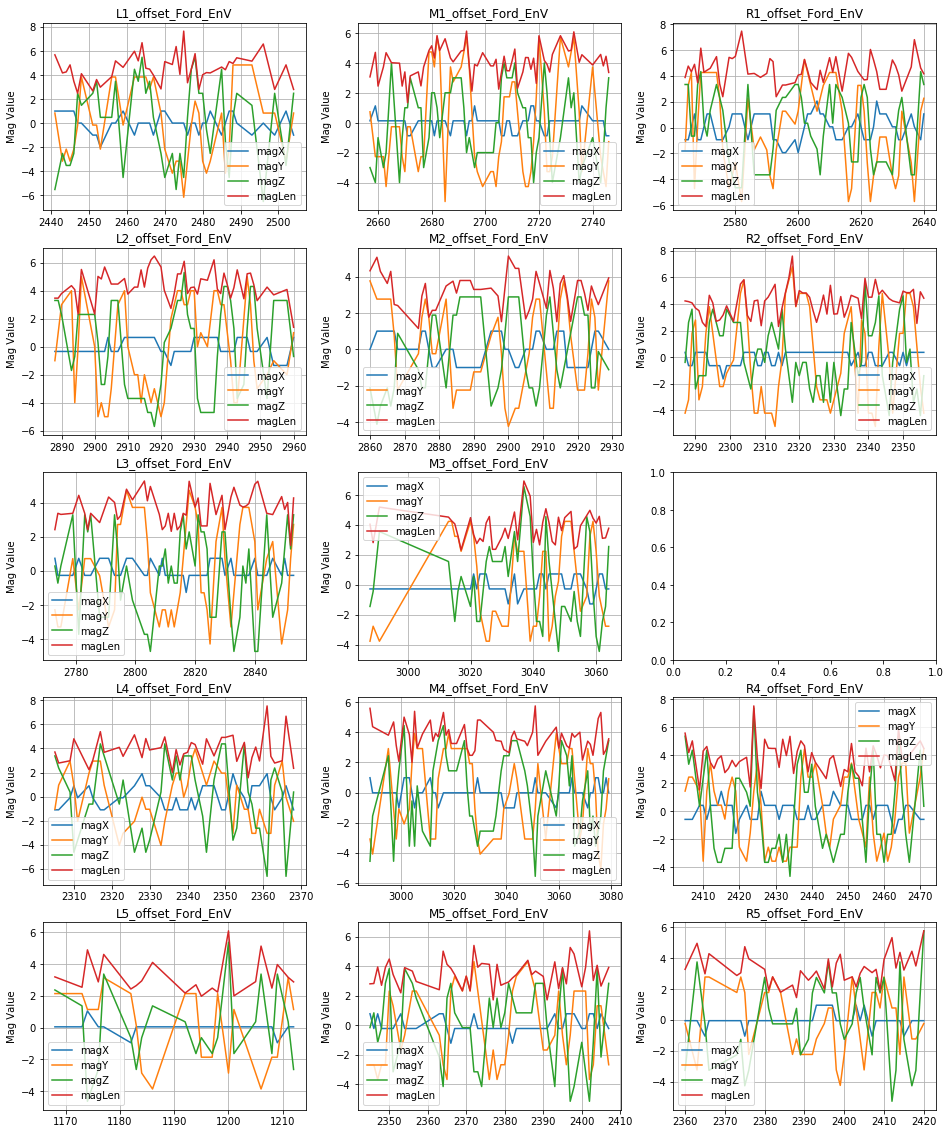

In [38]:
csvFiles = [f for f in listdir(folderName) if isfile(join(folderName, f)) and f[-3:] == "csv" ]
###################### single test #################################  

index = 0
plot_index = 0
Env_mag_array = list()
UTC_offset = 60*60*8

f, ax = plt.subplots(nrows=5, ncols=3, figsize=(16, 20))

for csv in csvFiles:
    df = pd.read_csv(folderName + csv, index_col=False, encoding='utf_8_sig')
    dfenv = get_secific_time_data(df, query_start_time, query_end_time)
    dfenvlen = len(dfenv)
    node_name = csv[0:2]
    get_data_lose_rate(node_name, query_data_points, dfenvlen)

    if (len(dfenv)):
        if experiemnt_Name == "EnV":
            Env_mag_array.append([dfenv.magX.mean(), dfenv.magY.mean() ,dfenv.magZ.mean()])
            print("Env MagX:", Env_mag_array[index][0], 
                  "MagY:", Env_mag_array[index][1], "MagZ:", Env_mag_array[index][2])
        else:
            Env_mag_array = pd.read_csv(save_env_name, encoding='utf_8_sig', index_col=0).values

        dfenv = get_mag_offset_data(dfenv, Env_mag_array[index][0], Env_mag_array[index][1], Env_mag_array[index][2], UTC_offset)
        title_Name = node_name + '_offset_' + carName + "_" + experiemnt_Name
        fast_plot_line(f, ax, plot_index, dfenv["frameCnt"] , dfenv["magX_of"],  dfenv["magY_of"], dfenv["magZ_of"], 
                       dfenv["magLen_of"] , title_Name , ylimit = None)
        dfenv.to_csv(folder_Experirmnt_Name + csv, encoding='utf_8_sig')
    else:
        print(csv, " doesn't contain this time interval data")
        if experiemnt_Name == "EnV":
            Env_mag_array.append([0, 0 ,0])
            print("Env MagX:", Env_mag_array[index][0], 
                  "MagY:", Env_mag_array[index][1], "MagZ:", Env_mag_array[index][2])

    index += 1
    plot_index += 1

    # pass R3 data, this node doesn't have data
    if index == 12:
        plot_index = 13


# imageName1 = folder_Experirmnt_Name + carName + "_" + experiemnt_Name + "_" + "Matrix.png"
# imageName2 =  folderName + carName + '/' + carName + "_" + experiemnt_Name + "_" + "Matrix.png"
# f.savefig(imageName1 ,bbox_inches='tight', dpi=200)     
# f.savefig(imageName2 ,bbox_inches='tight', dpi=200)  

if experiemnt_Name == "EnV":
    labels = ['MagX', 'MagY', 'MagZ']
    save_env_df = pd.DataFrame.from_records(Env_mag_array, columns=labels)
    save_env_df.to_csv(save_env_name ,encoding='utf_8_sig')

print("----------------------------------------------------------------------\n")


## Data prasing 
 1. lattency

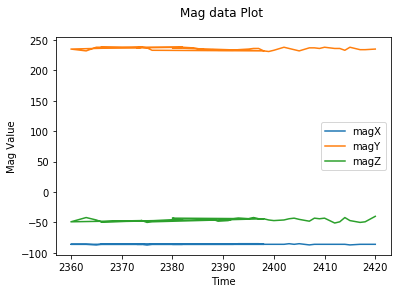

In [25]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
%matplotlib inline

df = pd.read_csv(csvFileName, encoding='utf_8_sig')
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

count = df.frameCnt
magX = df.magX
magY = df.magY
magZ = df.magZ
magT = df.magT

plt.figure()
plt.plot(count, magX, label='magX')
plt.plot(count, magY, label='magY')
plt.plot(count, magZ, label='magZ')
plt.xlabel('Time')
plt.ylabel('Mag Value')
plt.title('Mag data Plot \n ')
plt.legend()
plt.show()

# df2 = pd.DataFrame(np.random.rand(10, 4), columns=['magX', 'magX', 'magX', 'magX'])
# plt.figure(); df2.plot();

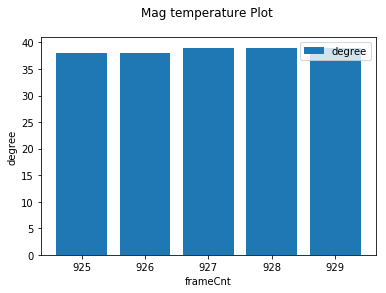

In [741]:
plt.figure()
plt.bar(count, magT, label='degree')
plt.xlabel('frameCnt')
plt.ylabel('degree')
plt.title('Mag temperature Plot \n ')
plt.legend()
plt.show()

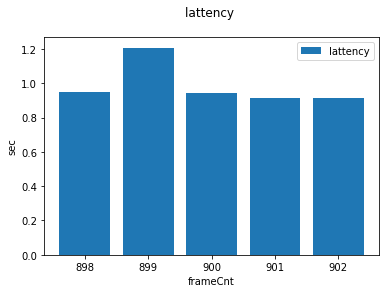

In [718]:
lattency = df.latency_time

plt.figure()
plt.bar(count, lattency, label='lattency')
plt.xlabel('frameCnt')
plt.ylabel('sec')
plt.title('lattency \n ')
plt.legend()
plt.show()